In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

from baseline import exhaustive, random_placement, heft, random_op_greedy_dev, random_op_est_dev
from env.utils import generate_program, generate_network
from env.network import StarNetwork
from env.program import Program
from env.latency import evaluate

from placement_rl.placement_env import PlacementEnv
from placement_rl.placement_agent import PlacementAgent

import os
import pickle

import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Using backend: pytorch


In [2]:
n_devices = [10, 20, 30]
n_operators = [10, 20, 30]
networks = {n: StarNetwork(*generate_network(n, seed=0)) for n in n_devices}
programs = {}
noises = [0, 0.01, 0.05, 0.1]
for n in n_devices:
    programs[n] = {}
    for m in n_operators:
        programs[n][m] = []
        for seed in range(5):
            DAG, constraints = generate_program(m, n, seed=seed)
            programs[n][m].append(Program(DAG, constraints))

In [3]:
with open('data/heft_data.pk', 'rb') as file:
    results = pickle.load(file)
print(results)

[[10, 10, 0, 0, 0.06717514991760254, [2, 8, 0, 8, 8, 9, 9, 0, 0, 8], tensor(660.5646, dtype=torch.float64)], [10, 10, 1, 0, 0.049162864685058594, [6, 6, 8, 8, 9, 9, 2, 8, 8, 0], tensor(445.9324, dtype=torch.float64)], [10, 10, 2, 0, 0.05240821838378906, [2, 4, 8, 9, 9, 9, 2, 2, 9, 3], tensor(574.8331, dtype=torch.float64)], [10, 10, 3, 0, 0.08099818229675293, [6, 6, 6, 2, 2, 1, 8, 0, 2, 7], tensor(647.0161, dtype=torch.float64)], [10, 10, 4, 0, 0.06606602668762207, [3, 3, 3, 1, 8, 3, 8, 8, 9, 3], tensor(485.9895, dtype=torch.float64)], [10, 20, 0, 0, 18.91101622581482, [0, 0, 2, 9, 2, 2, 9, 8, 0, 8, 0, 0, 8, 8, 0, 8, 8, 8, 4, 9], tensor(1316.5987, dtype=torch.float64)], [10, 20, 1, 0, 14.80750298500061, [6, 6, 2, 8, 8, 2, 8, 2, 8, 8, 9, 8, 8, 8, 1, 9, 2, 2, 6, 1], tensor(1199.4469, dtype=torch.float64)], [10, 20, 2, 0, 26.272990226745605, [3, 9, 2, 8, 2, 8, 8, 2, 2, 2, 8, 8, 9, 9, 2, 8, 2, 9, 8, 7], tensor(1180.6202, dtype=torch.float64)], [10, 20, 3, 0, 54.67387413978577, [8, 8, 8, 2,

In [4]:
heft_results = {}
heft_runtime = {}
for n_dev in n_devices:
    heft_results[n_dev] = {}
    heft_runtime[n_dev] = {}
    for n_op in n_operators:
        heft_results[n_dev][n_op] = []
        heft_runtime[n_dev][n_op] = []
        for seed in range(5):
            re = list(filter(lambda data: data[0]==n_dev and data[1]==n_op and data[2]==seed, results))
            heft_results[n_dev][n_op].append(re[0][5])
            heft_runtime[n_dev][n_op].append(re[0][4]/3600)
print(heft_runtime)


{10: {10: [1.8659763866000704e-05, 1.3656351301405164e-05, 1.4557838439941407e-05, 2.249949508243137e-05, 1.835167407989502e-05], 20: [0.005253060062726338, 0.00411319527361128, 0.007298052840762668, 0.015187187261051602, 0.005252463089095221], 30: [1.623804265525606, 2.4592042736212414, 3.8760948527521557, 2.6013788074917263, 1.220861612227228]}, 20: {10: [7.453163464864095e-05, 4.71447573767768e-05, 4.566470781962077e-05, 8.55030616124471e-05, 3.644333945380317e-05], 20: [0.009752824770079719, 0.013323610623677571, 0.008234515256351894, 0.03321694943639967, 0.00823184503449334], 30: [3.7820973502927355, 1.4894876858260897, 5.070714165502125, 6.799367664721277, 3.219905515511831]}, 30: {10: [6.671753194597032e-05, 7.797194851769341e-05, 9.474999374813503e-05, 9.803056716918946e-05, 7.386498981051974e-05], 20: [0.016473609209060668, 0.01666642751958635, 0.03265070584085253, 0.0519421288702223, 0.009457410309049818], 30: [10.233913405537605, 8.951479484703805, 18.230459003051124, 11.146

In [5]:
random_results = {}
random_runtime = {}
file = open('data/random_op_est_data.pk', 'rb')

for n_dev in n_devices:
    random_results[n_dev] = {}
    random_runtime[n_dev] = {}
    for n_op in n_operators:
        random_results[n_dev][n_op] = []
        random_runtime[n_dev][n_op] = []
        for seed, program in enumerate(programs[n_dev][n_op]):
            random_results[n_dev][n_op].append({})
            for noise in noises:
                r = pickle.load(file)
                assert r['n_devices'] == n_dev
                assert r['n_operators'] == n_op
                assert r['seed'] == seed
                assert r['noise'] == noise
                random_results[n_dev][n_op][-1][noise] = [[a[1], a[3]] for a in r['episodes']]
                random_runtime[n_dev][n_op].extend([a[0] for a in r['episodes']])
print(len(random_runtime[10][10]))

400


In [6]:
rl_result = {}
rl_runtime = {}
f = open('data/rl_op_data.pk', 'rb')

for n_dev in n_devices:
    rl_result[n_dev] = {}
    rl_runtime[n_dev] = {}
    for n_op in n_operators:
        rl_result[n_dev][n_op] = []
        rl_runtime[n_dev][n_op] = []
        for seed, program in enumerate(programs[n_dev][n_op]):
            rl_result[n_dev][n_op].append({})
            for noise in noises:
                r = pickle.load(f)
                assert r['n_devices'] == n_dev
                assert r['n_operators'] == n_op
                assert r['seed'] == seed
                assert r['noise'] == noise
                rl_result[n_dev][n_op][-1][noise] = [[a[1], a[3]] for a in r['episodes']]
                rl_runtime[n_dev][n_op].extend([a[0] for a in r['episodes']])
print(len(rl_runtime[10][10]))
    
# for n_dev in n_devices:
#     rl_result[n_dev] = {}
#     rl_runtime[n_dev] = {}
#     for n_op in n_operators:
#         rl_result[n_dev][n_op] = {}
#         rl_runtime[n_dev][n_op] = []
#         for seed, program in enumerate(programs[ndev][nop]):
#             rl_result[n_dev][n_op][seed] = {}
#             for noise in noises:
#                 r = list(filter(lambda data: data['n_devices']==n_dev and data['n_operators']==n_op and data['seed']==seed and data['noise']==noise, objs))
#                 if len(r):
#                     rl_result[n_dev][n_op][seed][noise] = [a[1] for a in r[0]['episodes']]
#                     rl_runtime[n_dev][n_op].extend([a[0] for a in r[0]['episodes']])
# print(rl_runtime)

400


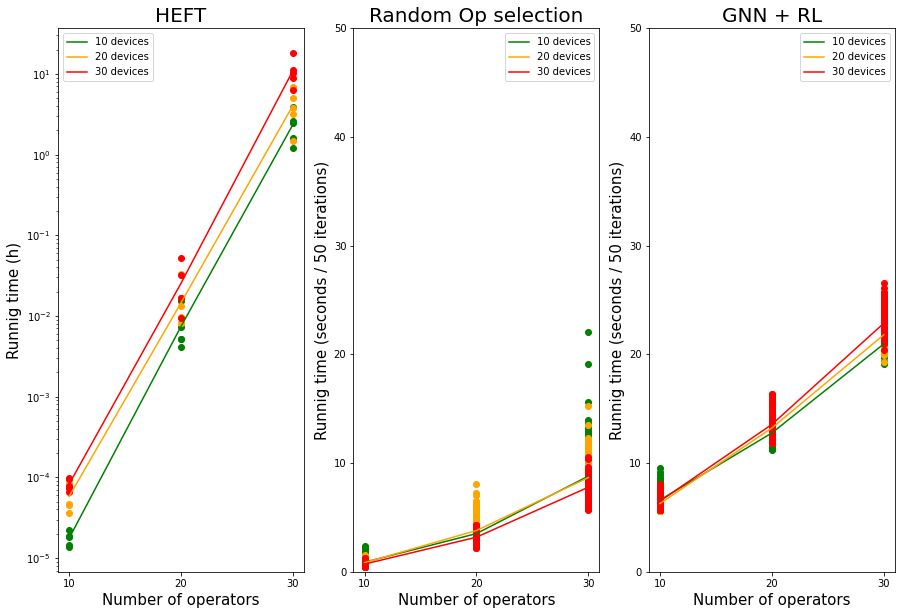

In [7]:
color = {10: 'green', 20: 'orange', 30: 'red'}
fix, axes = plt.subplots(1, 3, figsize=(15,10), sharex=True)
for n_dev in heft_runtime:
    axes[0].plot(np.arange(10, 31, 10), [np.average(heft_runtime[n_dev][n]) for n in heft_runtime[n_dev]], label=f'{n_dev} devices', color=color[n_dev])
    axes[1].plot(np.arange(10, 31, 10), [np.average(random_runtime[n_dev][n]) for n in random_runtime[n_dev]], label=f'{n_dev} devices', color=color[n_dev])
    axes[2].plot(np.arange(10, 31, 10), [np.average(rl_runtime[n_dev][n]) for n in rl_runtime[n_dev]], label=f'{n_dev} devices', color=color[n_dev])

    for n_op in heft_runtime[n_dev]:
        axes[0].scatter(n_op*np.ones(len(heft_runtime[n_dev][n_op])), heft_runtime[n_dev][n_op], color=color[n_dev])
        axes[1].scatter(n_op*np.ones(len(random_runtime[n_dev][n_op])), random_runtime[n_dev][n_op], color=color[n_dev])
        axes[2].scatter(n_op*np.ones(len(rl_runtime[n_dev][n_op])), rl_runtime[n_dev][n_op], color=color[n_dev])

axes[0].set_yscale('log')

axes[0].set_title('HEFT', fontsize=20)
axes[1].set_title('Random Op selection', fontsize=20)
axes[2].set_title('GNN + RL', fontsize=20)

# plt.tight_layout()
axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].set_ylabel('Runnig time (h)', fontsize=15)
axes[1].set_ylabel('Runnig time (seconds / 50 iterations)', fontsize=15)
axes[2].set_ylabel('Runnig time (seconds / 50 iterations)', fontsize=15)

axes[1].set_ylim([0, 50])
axes[2].set_ylim([0, 50])

axes[0].set_xlabel('Number of operators', fontsize=15)
axes[1].set_xlabel('Number of operators', fontsize=15)
axes[2].set_xlabel('Number of operators', fontsize=15)

plt.xticks(np.arange(10, 31, 10))
plt.show()

In [19]:
for ndev in [10]:
    for nop in [10]:
        network = networks[ndev]
        program = programs[ndev][nop][seed]
        for seed in [0]:
            for noise in [0.1]:
                random_trace = np.array([random_results[ndev][nop][seed][noise][i][1] for i in range(n_episodes)])
                random_diff = -np.diff(random_trace)
                
                print(np.argmax(random_diff @ factor))
                print(random_trace[16])


16
[1130.4422148   910.51405959  910.51405959  786.71603706  785.39912342
  773.20868919  777.19246914  768.90309066  774.43158701  779.48066113
  786.19351693  807.36160007  698.71653708  698.71653708  704.27945164
  699.77713696  694.81784355  674.4421754   672.79647026  664.20412088
  664.20412088  674.42776778  676.85789703  658.46196544  671.04414715
  662.48469696  671.94801427  667.92558684  655.31316418  655.31316418
  676.15759408  674.37004126  660.05073821  686.73693947  651.28815604
  651.28815604  663.71504011  661.67570291  687.8778991   691.6631963
  693.06791441  681.18908067  702.80427229  637.45276723  651.60696382
  652.9141725   660.43383256  662.37780025  672.11445302  674.20898179
  663.51936138]


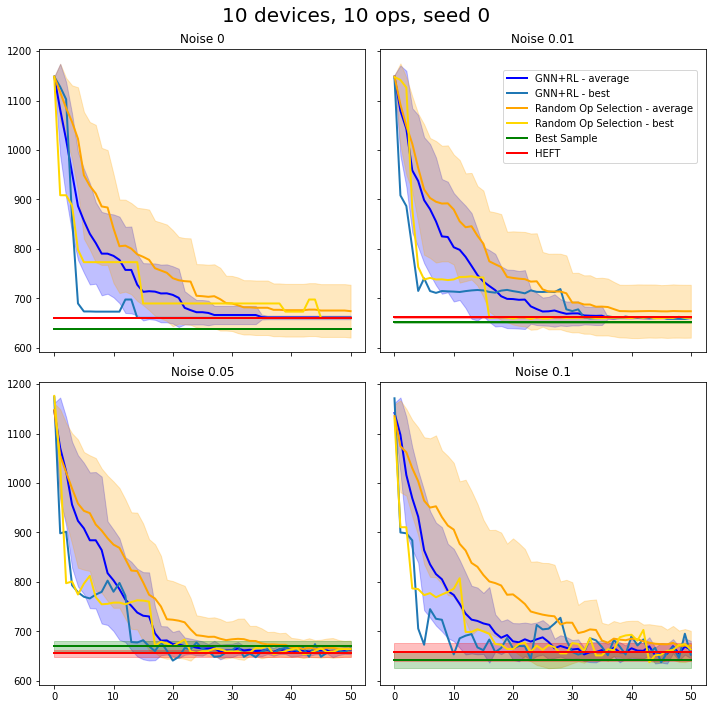

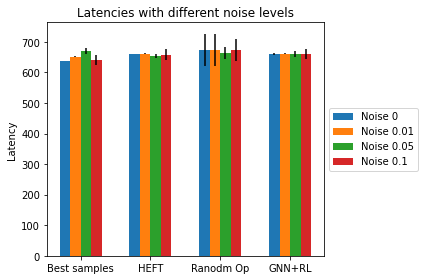

In [24]:
from env.latency import simulate

n_episodes = 20
n_iter = 50

# for ndev in n_devices:
#     for nop in n_operators:
#         for program in programs[ndev][nop]:
#             print(program.placement_constraints)
def plot_four(ndev, nop, seed):
    fig, axs = plt.subplots(2, 2, figsize=(10,10), sharey=True, sharex=True)
    network = networks[ndev]
    program = programs[ndev][nop][seed]
    
    factor = np.array([0.95**i for i in range(50)])
    
    l_mean = {}
    l_std = {}
    for j, noise in enumerate(noises):

        sample_map, sample_latency, sample_latencies = random_placement(program, network, n_iter * n_episodes, noise)
        _, sample_latencies, _ = simulate(sample_map, program, network, noise, repeat = 10)
        sample_mean = np.average(sample_latencies)
        sample_std = np.std(sample_latencies)
        
        
        heft_map = heft_results[ndev][nop][seed]
        _, heft_latencies, _ = simulate(heft_map, program, network, noise, repeat = 10)
        heft_mean = np.average(heft_latencies)
        heft_std = np.std(heft_latencies)
        
        random_maps = [random_results[ndev][nop][seed][noise][i][0] for i in range(n_episodes)]
        random_latencies = np.array([simulate(random_map, program, network, noise, repeat = 10)[1] for random_map in random_maps])
        random_mean = np.average(random_latencies)
        random_std = np.std(random_latencies)
        
        rl_maps = [rl_result[ndev][nop][seed][noise][i][0] for i in range(n_episodes)]
        rl_latencies = np.array([simulate(rl_map, program, network, noise, repeat = 10)[1] for rl_map in rl_maps])
        rl_mean = np.average(rl_latencies)
        rl_std = np.std(rl_latencies)
        
        l_mean[noise] = [sample_mean, heft_mean, random_mean, rl_mean]
        l_std[noise] = [sample_std, heft_std, random_std, rl_std]
        
        random_trace = np.array([random_results[ndev][nop][seed][noise][i][1] for i in range(n_episodes)])
        random_diff = -np.diff(random_trace)
        random_reward = random_diff @ factor
        
        rl_trace = np.array([rl_result[ndev][nop][seed][noise][i][1] for i in range(n_episodes)])
        rl_diff = -np.diff(rl_trace)
        rl_reward = rl_diff @ factor

        x = j //2
        y = j % 2
        
        
        axs[x, y].plot(range(n_iter+1), np.average(rl_trace, axis=0), label = "GNN+RL - average", color='blue', linewidth=2)
        axs[x, y].plot(range(n_iter+1), rl_trace[np.argmax(rl_reward)], label = "GNN+RL - best", color='tab:blue', linewidth=2)
        axs[x, y].fill_between(range(n_iter+1), np.average(rl_trace, axis=0) + np.std(rl_trace, axis=0), np.average(rl_trace, axis=0) - np.std(rl_trace, axis=0), alpha=.25, color='blue')

        axs[x, y].plot(range(n_iter+1), np.average(random_trace, axis=0), label=f'Random Op Selection - average', color='orange', linewidth=2)
        axs[x, y].plot(range(n_iter+1), random_trace[np.argmax(random_reward)], label = f'Random Op Selection - best', color='gold', linewidth=2)
        axs[x, y].fill_between(range(n_iter+1), np.average(random_trace, axis=0) + np.std(random_trace, axis=0), np.average(random_trace, axis=0) - np.std(random_trace, axis=0), alpha=.25, color='orange')

        axs[x, y].plot(range(n_iter+1), torch.ones(n_iter+1) * sample_mean, label=f'Best Sample', color='green', linewidth=2)
        axs[x, y].fill_between(range(n_iter+1), torch.ones(n_iter+1) *(sample_mean + sample_std), torch.ones(n_iter+1) *(sample_mean - sample_std), alpha=.25, color='green')

        axs[x, y].plot(range(n_iter+1), torch.ones(n_iter+1) * heft_mean, label='HEFT', color='red', linewidth=2)
        axs[x, y].fill_between(range(n_iter+1), torch.ones(n_iter+1) *(heft_mean + heft_std), torch.ones(n_iter+1) *(heft_mean - heft_std), alpha=.25, color='red')


        axs[x, y].set_title(f'Noise {noise}')
        
    handles, labels = axs[x, y].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.9,0.8, 0.08, 0.1), fontsize=10)
    fig.suptitle(f'{ndev} devices, {nop} ops, seed {seed}', fontsize=20)
    fig.tight_layout()
    
    fig, ax = plt.subplots()
    labels = ['Best samples', 'HEFT', 'Ranodm Op', 'GNN+RL']
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars
    noise_loc = {0: -1.5, 0.01: -0.5,0.05: 0.5, 0.1: 1.5}
    for noise in noises:
        rect = ax.bar(x + width*noise_loc[noise], l_mean[noise], width, yerr=l_std[noise], label=f'Noise {noise}')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Latency')
    ax.set_title('Latencies with different noise levels')
    ax.set_xticks(x, labels)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.tight_layout()

    plt.show()

plot_four(10, 10, 0)

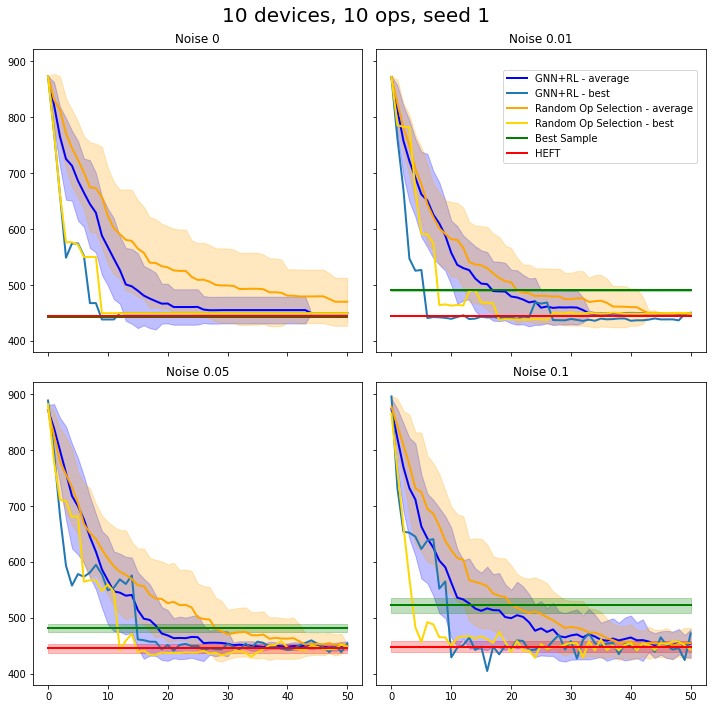

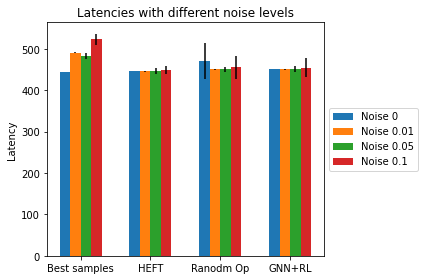

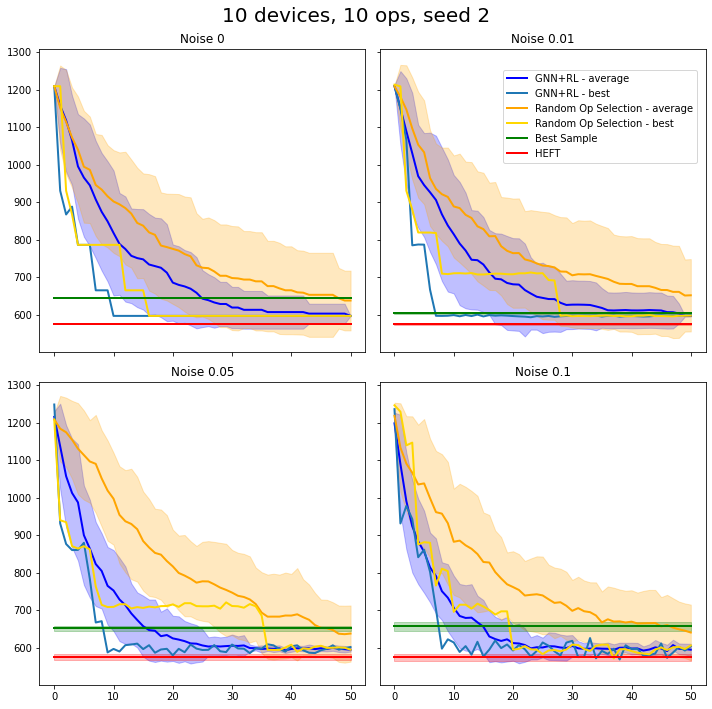

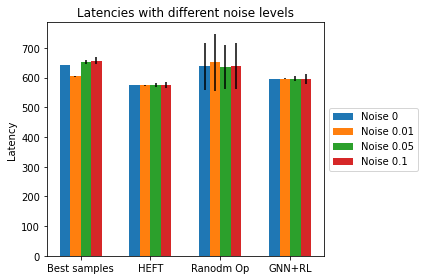

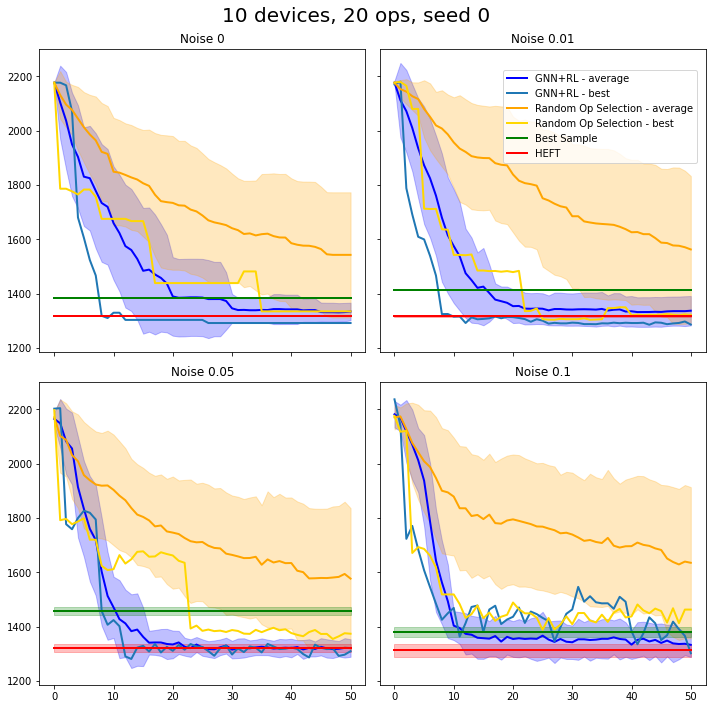

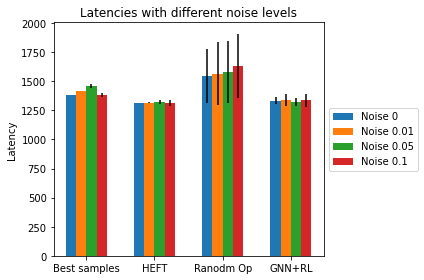

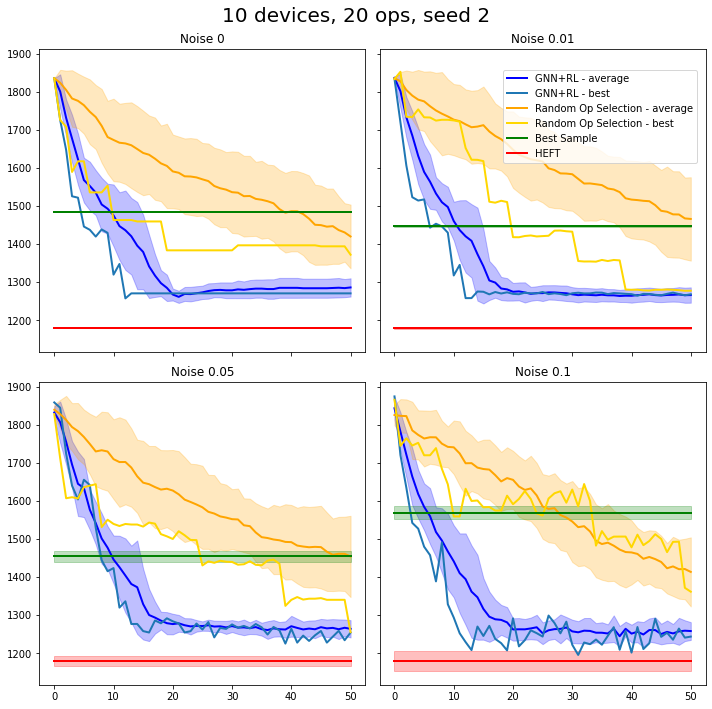

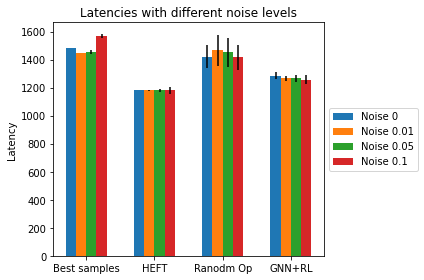

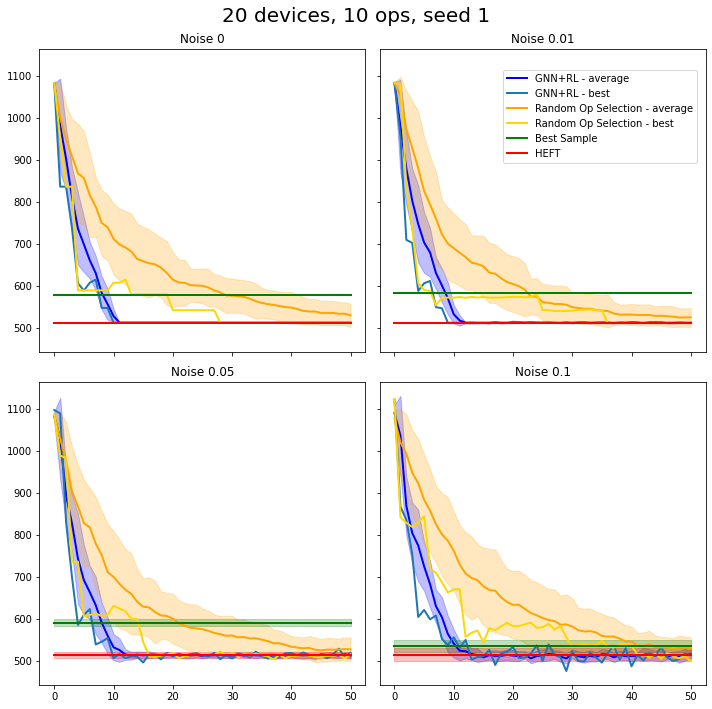

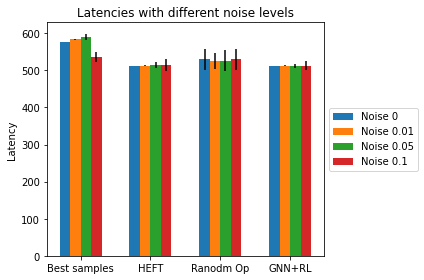

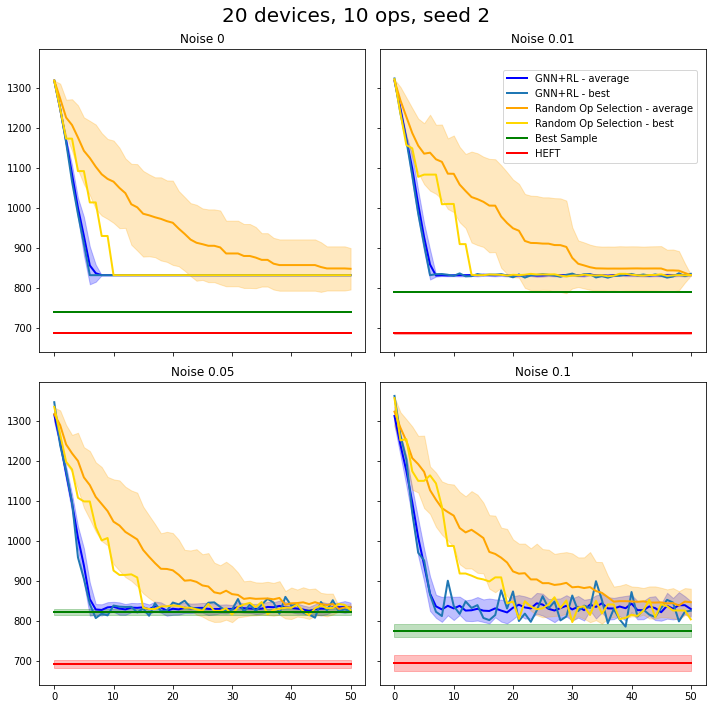

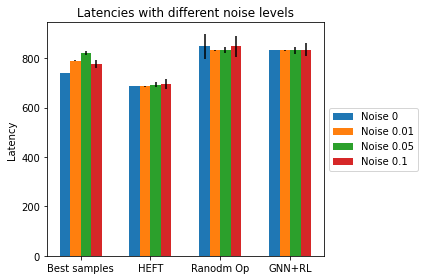

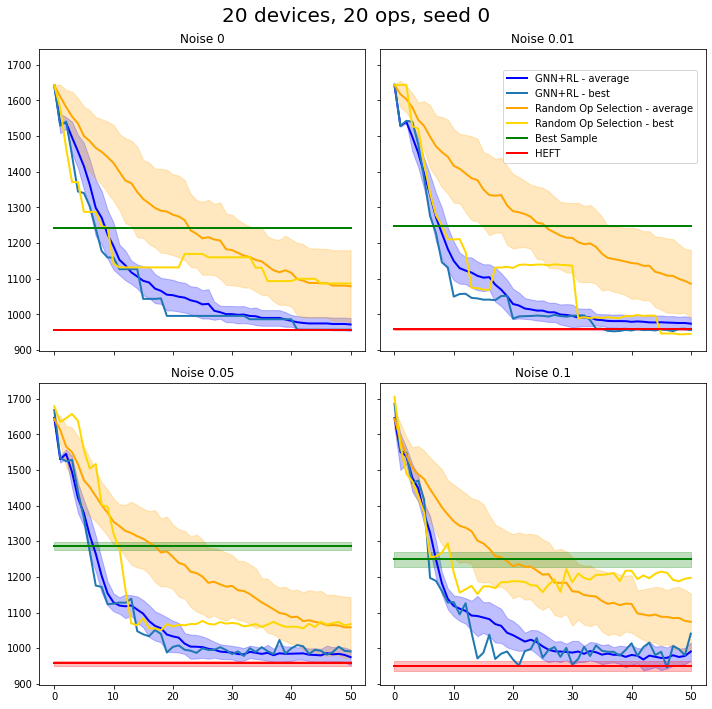

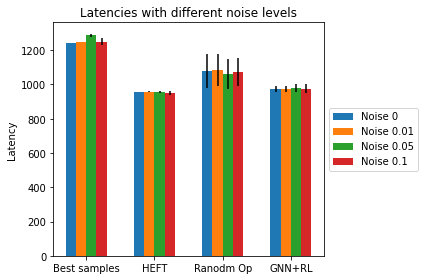

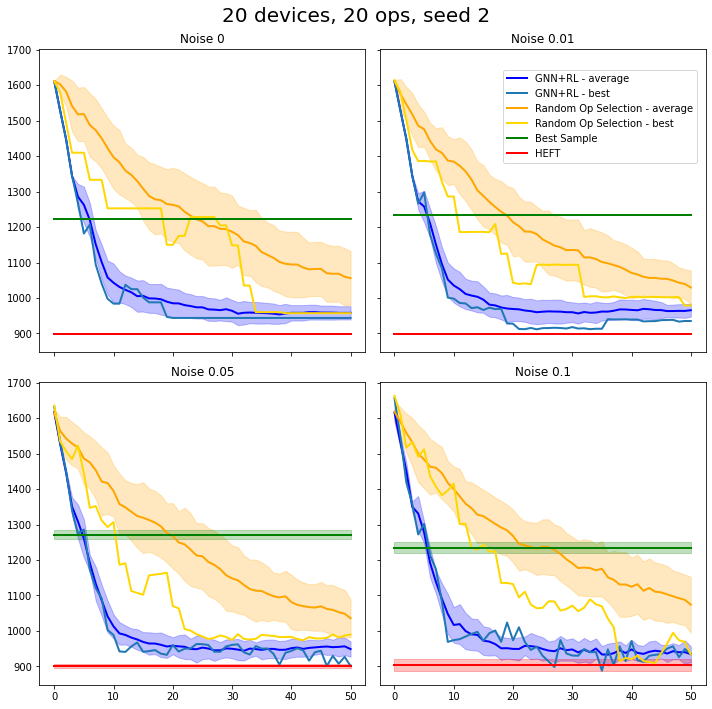

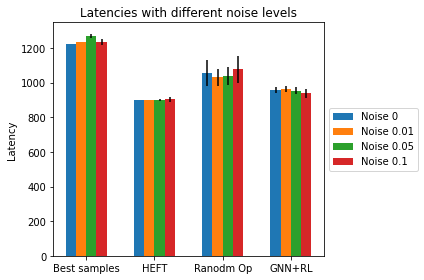

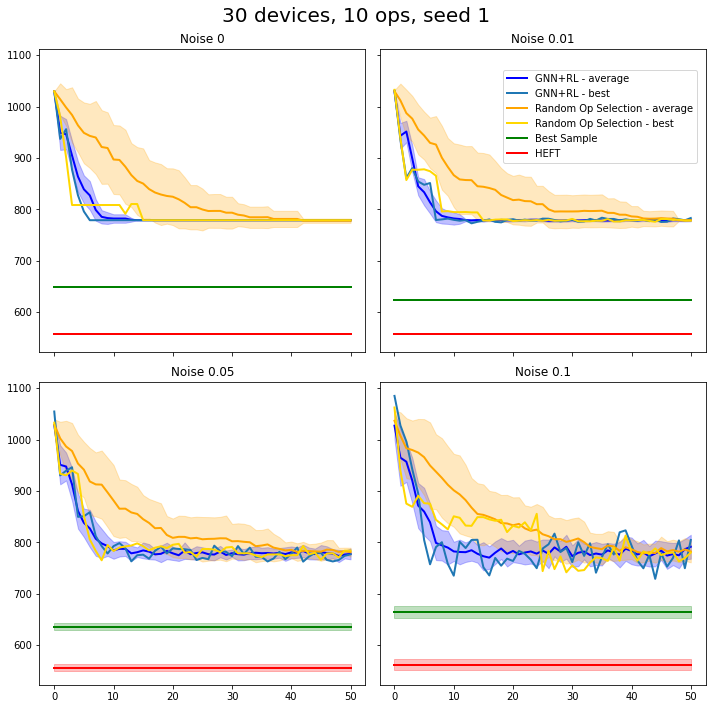

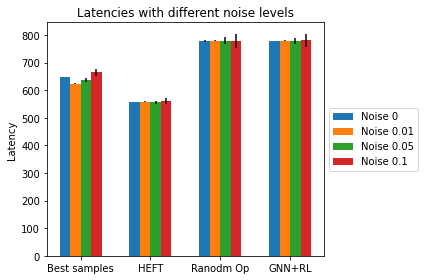

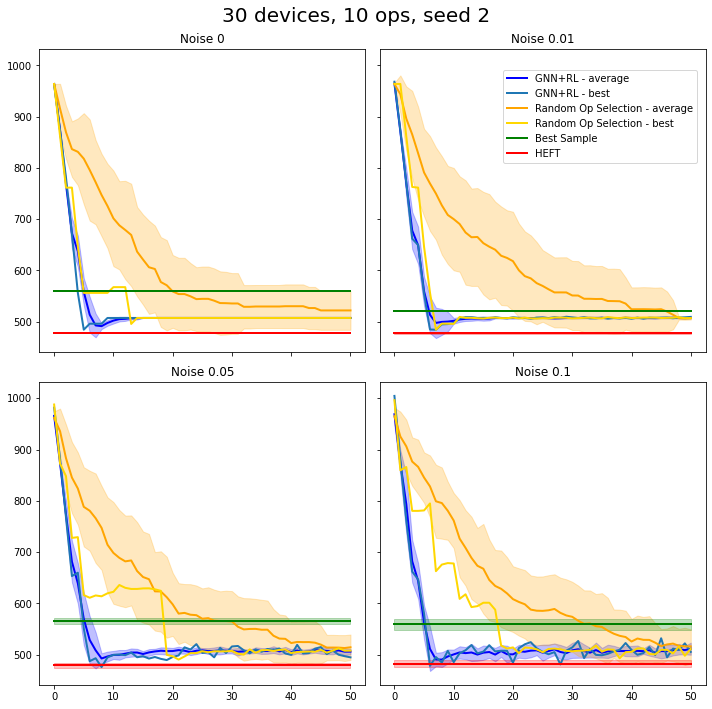

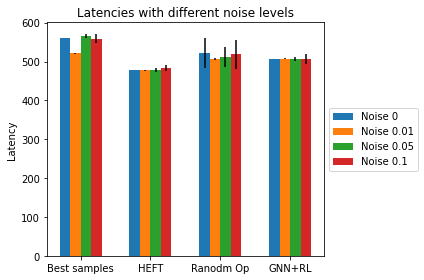

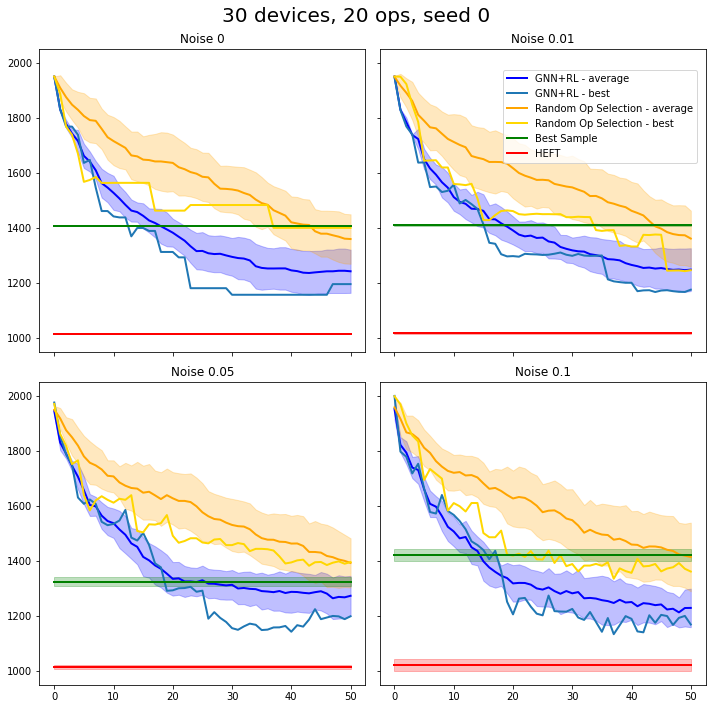

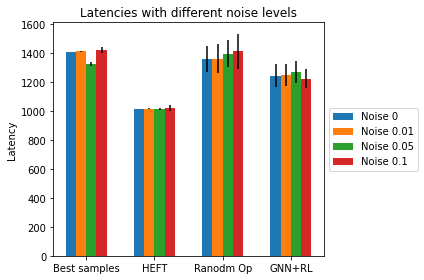

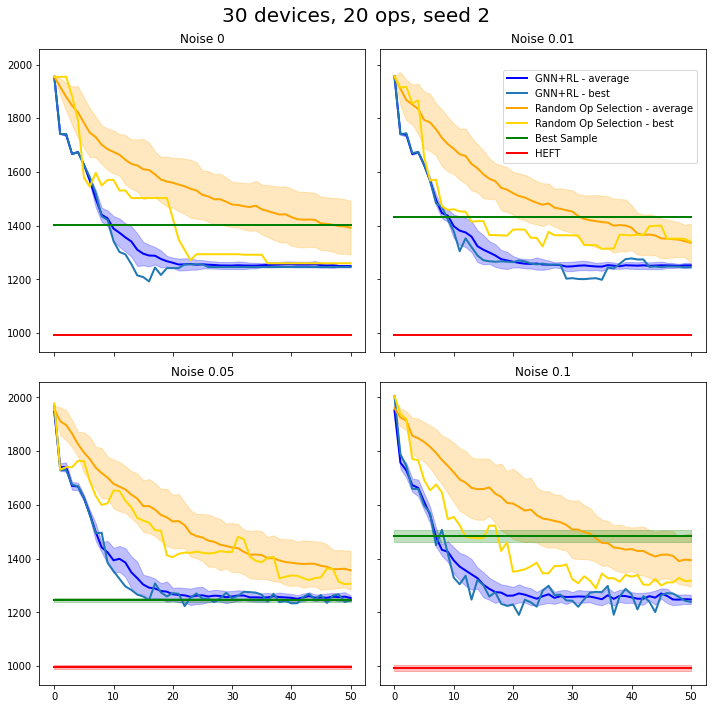

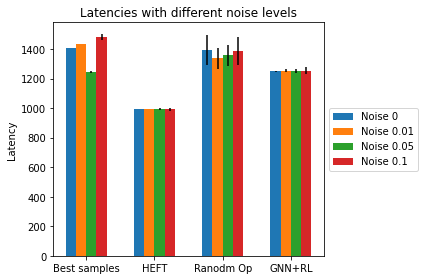

In [25]:
plot_four(10, 10, 1)
plot_four(10, 10, 2)
plot_four(10, 20, 0)
plot_four(10, 20, 2)

plot_four(20, 10, 1)
plot_four(20, 10, 2)
plot_four(20, 20, 0)
plot_four(20, 20, 2)

plot_four(30, 10, 1)
plot_four(30, 10, 2)
plot_four(30, 20, 0)
plot_four(30, 20, 2)